## Objective: Model sediment erosion and deposition from fluvial processes

#### Inputs: Eightmile Lake, AK DEM at 2m / px resolution
#### Components: Space, FlowAccumulator, DepressionFinderAndRouter, FastscapeEroder
#### Outputs: sediment flux

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import rasterio as rio

from landlab import RasterModelGrid
from landlab.plot import imshow_grid
from landlab.components import Space, FlowAccumulator, DepressionFinderAndRouter, FastscapeEroder

/home/egp/.virtualenvs/landlab/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## 1) Import and downsample DEM

In [2]:
current = 2 # meters per pixel
target = 30 # meters per pixel
scale = current / target

with rio.open('./gis/projects/dem/eightmile-lake-watershed-dem-filled.tif') as src:

    # resample data to target shape
    data = src.read(
        out_shape = (
            src.count,
            int(src.height * scale),
            int(src.width * scale)
        ),
        resampling = rio.enums.Resampling.bilinear
    )

    # scale image transform
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )

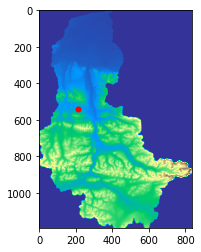

In [3]:
dem = np.flip(np.transpose(data[0]), 0)

plt.imshow(dem, cmap = 'terrain')
plt.scatter(210, 540, s = 25, color = 'red')
plt.show()

## 2) Set initial and boundary conditions

In [4]:
grid = RasterModelGrid([dem.shape[0], dem.shape[1]], target)

In [5]:
grid.add_field('topographic__elevation', np.flip(dem.astype(float), 0), at = 'node', clobber = True, copy = True) 

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [6]:
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__elevation'], 0)
grid.set_closed_boundaries_at_grid_edges(
    bottom_is_closed = True,
    top_is_closed = True,
    right_is_closed = True,
    left_is_closed = True
)

In [7]:
outlet_id = grid.set_watershed_boundary_condition('topographic__elevation', nodata_value = 0, return_outlet_id = True,
                                                  remove_disconnected = True, adjacency_method = 'D8')

In [8]:
outlet_coords = (grid.node_x[outlet_id], grid.node_y[outlet_id])

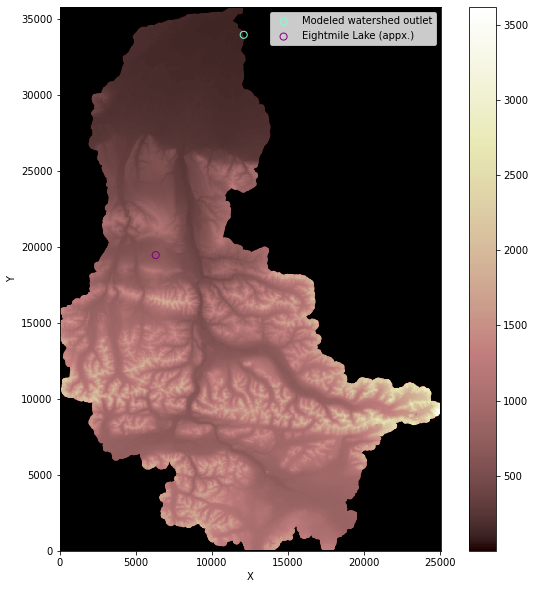

In [9]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'topographic__elevation')
plt.scatter(outlet_coords[0], outlet_coords[1], color = 'aquamarine', s = 50, facecolors = 'none', label = 'Modeled watershed outlet')
plt.scatter(6300, 19440, s = 50, color = 'purple', facecolors = 'none', label = 'Eightmile Lake (appx.)')
plt.legend(loc = 'upper right')
plt.show()

## 3) Burn a stream network using Fastscape

In [10]:
fast_dt = 100
FA = FlowAccumulator(grid, flow_director = 'D8')
DF = DepressionFinderAndRouter(grid)
FE = FastscapeEroder(grid, K_sp = 0.001, m_sp = 0.5, n_sp = 1)

In [11]:
nt = 25

for t in range(nt):
    FA.run_one_step()
    DF.map_depressions()
    FE.run_one_step(dt = fast_dt)
    
    if (t + 1) % 5 == 0:
        print('Completed ' + str(t + 1) + ' time steps.')

Completed 5 time steps.
Completed 10 time steps.
Completed 15 time steps.
Completed 20 time steps.
Completed 25 time steps.


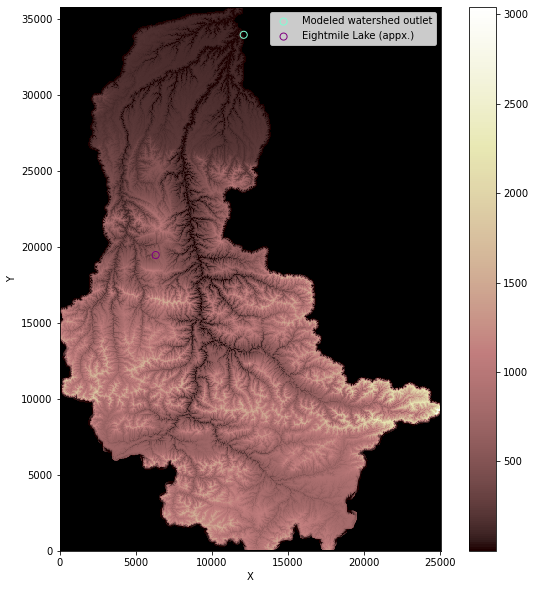

In [12]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'topographic__elevation', cmap = 'pink')
plt.scatter(outlet_coords[0], outlet_coords[1], color = 'aquamarine', s = 50, facecolors = 'none', label = 'Modeled watershed outlet')
plt.scatter(6300, 19440, s = 50, color = 'purple', facecolors = 'none', label = 'Eightmile Lake (appx.)')
plt.legend(loc = 'upper right')
plt.show()

## 4) Initialize components

In [13]:
grid.add_zeros('soil__depth', at = 'node', clobber = True)
grid.at_node['soil__depth'] += 0.5
grid.at_node['topographic__elevation'] += grid.at_node['soil__depth']

In [14]:
SP = Space(
    grid,
    K_sed = 1e-5,
    K_br = 1e-11,
    F_f = 0.5,
    phi = 0.1,
    H_star = 1.,
    v_s = 1e-3,
    m_sp = 0.5,
    n_sp = 1.0,
    sp_crit_sed = 0,
    sp_crit_br = 0
)

In [15]:
nt = 25
space_dt = 100
count = 0
initial_topography = grid.at_node['topographic__elevation']

for t in range(nt):
    FA.run_one_step()
    DF.map_depressions()
    SP.run_one_step(dt = space_dt)
    
    count += 1
    if count % 5 == 0:
        print('Completed ' + str(count) + ' time steps.')

Completed 5 time steps.
Completed 10 time steps.
Completed 15 time steps.
Completed 20 time steps.
Completed 25 time steps.



KeyboardInterrupt



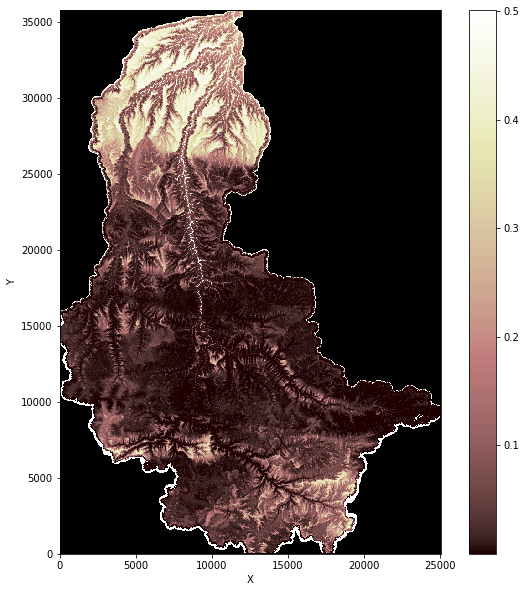

In [19]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'soil__depth')
# plt.scatter(outlet_coords[0], outlet_coords[1], color = 'aquamarine', s = 50, facecolors = 'none', label = 'Modeled watershed outlet')
# plt.scatter(6300, 19440, s = 50, color = 'purple', facecolors = 'none', label = 'Eightmile Lake (appx.)')
# plt.legend(loc = 'upper right')
plt.show()

In [28]:
slope = grid.calc_slope_at_node('topographic__elevation')

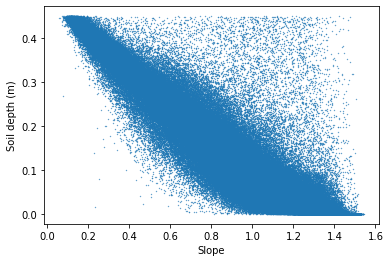

In [29]:
plt.scatter(slope[grid.at_node['soil__depth'] < 0.45], grid.at_node['soil__depth'][grid.at_node['soil__depth'] < 0.45], s = 0.1)
plt.xlabel('Slope')
plt.ylabel('Soil depth (m)')
plt.show()